In [2]:
import os
from scipy.io import loadmat
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter,filtfilt, lfilter
from scipy import signal
from scipy.ndimage import convolve1d


# 1D Signals - analysis in time

## Part 1 - Synthetic signals

In this first part
- we generate a synthetic signal 
- (optionally you may add noise as we did in the previous lab)
- learn how to apply a smoothing filter (Gaussian or Hamming) with a convolution
- add salt & papper (impulsive) noise
- learn how it cannot be solved with a smoothing filter
- learn that if can be attenuated by a median filter

Text(0, 0.5, 'y')

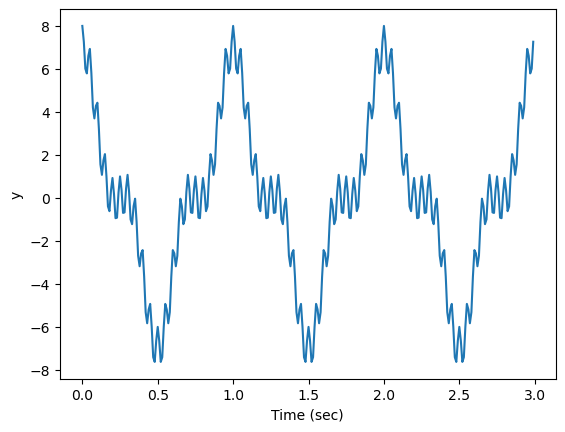

In [25]:
delta_s = 1./100; #sampling interval
f_s = 1./delta_s; #sampling frequency
f = 1.0 # Hz # sinusoidal signal frequency
T = 3.0;
time = np.arange(0.0, T, delta_s) # sampling points at f_s frequency
N=time.size; 

f = 5*np.cos(2 * np.pi * f * time) + 1* np.cos(10 * 4 * np.pi * f * time) + 2* np.cos(3 * 2 * np.pi * f * time) 
plt.plot(time, f)
plt.xlabel("Time (sec)")
plt.ylabel("y")

Text(0.5, 1.0, 'Filtered signal')

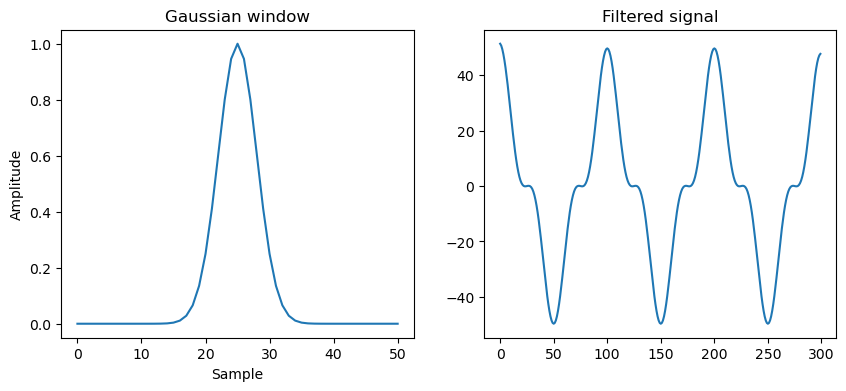

In [15]:
from scipy import signal
windowg = signal.windows.gaussian(51, std=3)
filt=convolve1d(f,windowg) 

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(windowg)
plt.title("Gaussian window")
plt.ylabel("Amplitude")
plt.xlabel("Sample")

plt.subplot(1,2,2)
plt.plot(filt)
plt.title("Filtered signal")

Check the function <tt> signal.windows</tt> there are many other options

Text(0.5, 1.0, 'Filtered signal')

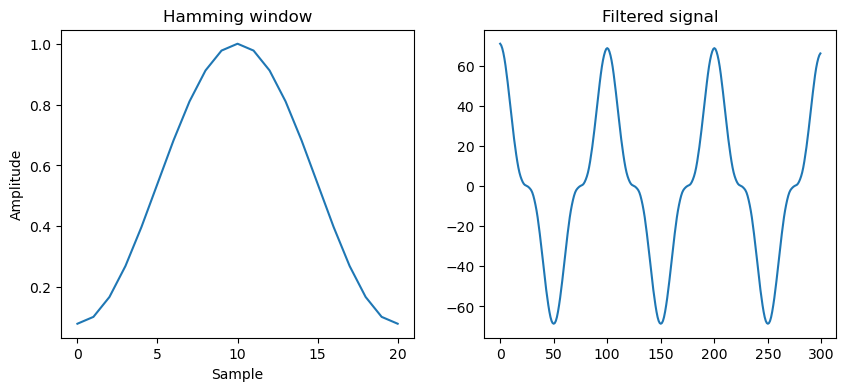

In [18]:
# another filter
window = signal.windows.hamming(21)
filt2=convolve1d(f,window) 

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(window)
plt.title("Hamming window")
plt.ylabel("Amplitude")
plt.xlabel("Sample")

plt.subplot(1,2,2)
plt.plot(filt2)
plt.title("Filtered signal")


Not all the noise can be solved with smoothing (low pass) linear filters. An example is impulsive (or "salt & pepper") noise

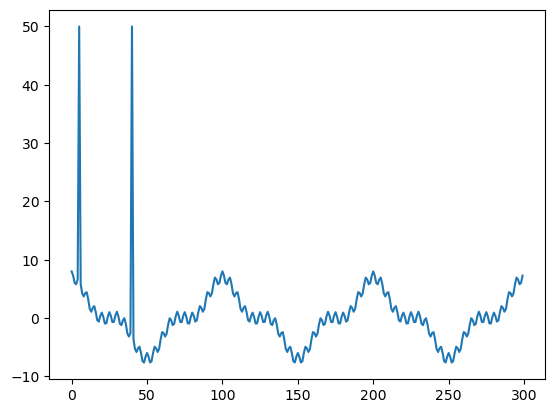

In [22]:
f1 = np.copy(f)
#adding impulsive noise
f1[5] = f1[40] = 50
plt.plot(f1)


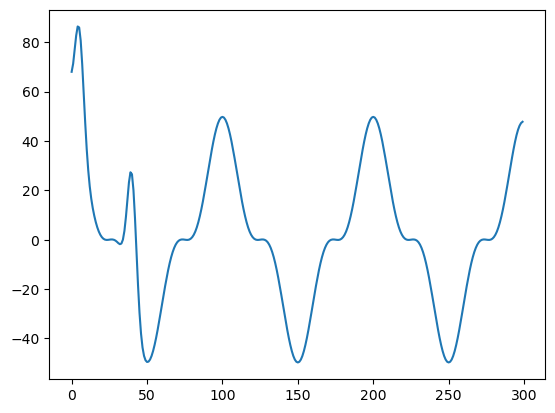

In [23]:
# smoothing filters fail
filt1=convolve1d(f1,windowg)
plt.plot(filt1)

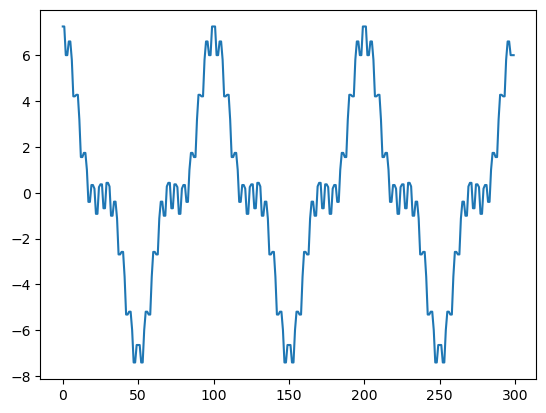

In [24]:
# IT'S NON LINEAR! it's not a convolution
# median filters are the ideal choice!
filt_med=signal.medfilt(f, kernel_size=None) 
plt.plot(filt_med)

## Part 2 - Real signals
We now play with real time series. They have been obtained by tracking keypoints in image sequences of newborn (see Figure)  

<img src="Picture.png">

We have 5 anatomical keypoints, each of them associated with x and y coordinates on the image plane; each video is associated 10 time series, synchronous in time. <br>
I suggest you try with several time series and several portions.

In [26]:
# load data
patient = 'PT12_40'

data_o = loadmat(patient+'_original.mat')
data_orig = data_o['data_orig']

In [27]:
#dimension

print(np.shape(data_orig))

(6896, 10)


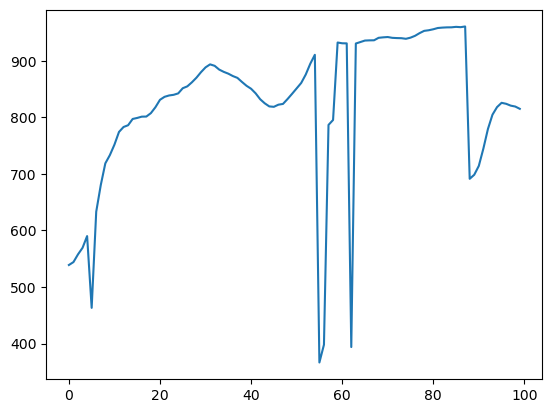

In [28]:
# we pick one of the 10 time series
idx_data = 7 #choose an index between 1 and 10  
# time series are very long, we pick a portion [min,max]
min = 0
max = 100

plt.plot(data_orig[min:max,idx_data]) 
 

### Smoothing Filters

Let us apply smoothing filters first

In [29]:

windowg = signal.windows.gaussian(31, std=0.6) #change values
windowg /= sum(windowg) # what is it for?
filt=convolve1d(data_orig[:,idx_data],windowg) 
 

In [30]:
windowg

array([1.27356612e-136, 3.95765678e-119, 7.64682586e-103, 9.18651335e-088,
       6.86193595e-074, 3.18690450e-061, 9.20275536e-050, 1.65231614e-039,
       1.84456877e-030, 1.28033317e-022, 5.52557630e-016, 1.48271815e-010,
       2.47380844e-006, 2.56625595e-003, 1.65523748e-001, 6.63815045e-001,
       1.65523748e-001, 2.56625595e-003, 2.47380844e-006, 1.48271815e-010,
       5.52557630e-016, 1.28033317e-022, 1.84456877e-030, 1.65231614e-039,
       9.20275536e-050, 3.18690450e-061, 6.86193595e-074, 9.18651335e-088,
       7.64682586e-103, 3.95765678e-119, 1.27356612e-136])

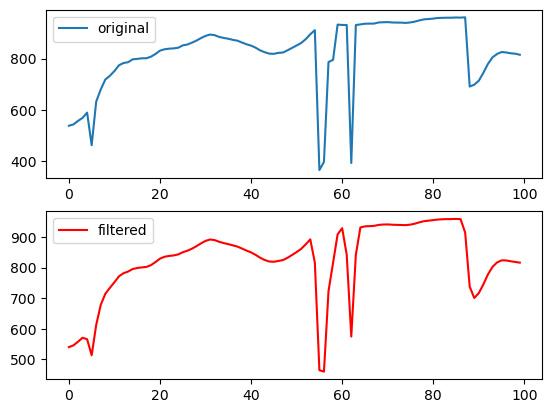

In [31]:
plt.figure()
plt.subplot(211)
plt.plot(data_orig[min:max,idx_data])
plt.legend(['original'])
plt.subplot(212)
plt.plot(filt[min:max],'r')
plt.legend(['filtered'])
plt.show()

### Median filter

These data include occasional gaps and local errors due to occlusions. A median filter could be appropriate

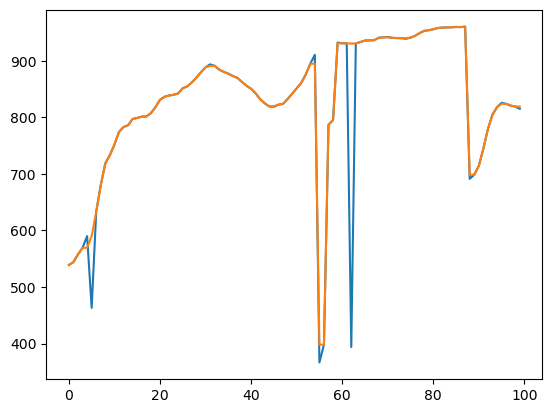

In [32]:
filt_med=signal.medfilt(data_orig[:,idx_data], kernel_size=None) 
plt.plot(data_orig[min:max,idx_data])
plt.plot(filt_med[min:max])

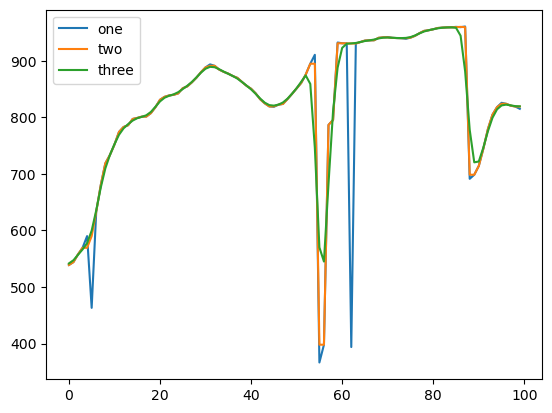

In [18]:
# PIPELINE  

filt_med=signal.medfilt(data_orig[:,idx_data], kernel_size=None) 
windowg = signal.windows.gaussian(51, std=1) #change the values  
windowg /= sum(windowg)
filt=convolve1d(filt_med,windowg) 


plt.plot(data_orig[min:max,idx_data]) 
plt.plot(filt_med[min:max]) 
plt.plot(filt[min:max]) 
#plt.legend(['original','median','lowpass'])
plt.legend(['one','two','three'])


## Finite differences

We now estimate the derivatives looking for ingresing, decreasing, constant portions of the signal

In [33]:
dx = 1   #increment 
cf = np.convolve(filt, [-0.5, 0, 0.5 ]) / dx 
#cf = np.convolve(filt, [1,-1 ]) / dx 

(2,)
(2,)


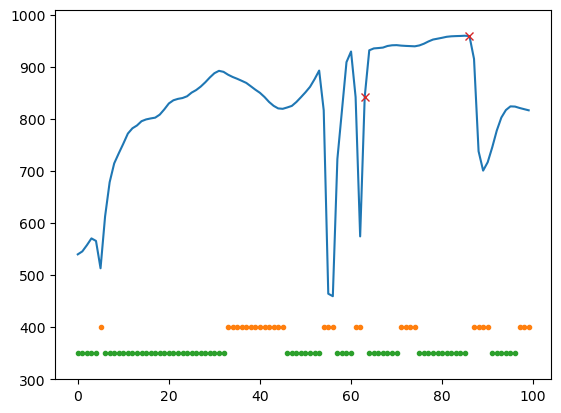

In [34]:
filt_plot = filt[min:max]
toll=0.2
plt.plot(filt_plot)
top = np.max(filt_plot)
bottom = np.min(filt_plot)
plt.plot(400*(cf[min:max]>toll),".") #descending
plt.plot(350*(cf[min:max]<-toll),".") #ascending
extr =  np.where(abs(cf[min:max])<toll)  #extrema (minima/maxima)
plt.plot(extr[0],filt_plot[extr],"x")

plt.ylim(300,top+50)
print(np.shape(filt[extr]))
print(np.shape(extr[0]))

Notice here we detect "multiple" adjacent extrema . We would need to apply a <i> non-maxima suppression </i> step. We will not go into the details of this refinement.

Instead we test a function you may find in the <tt>scipy </tt> library. 
### Peaks detection

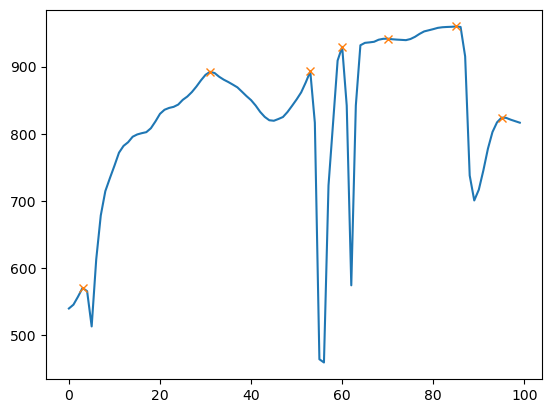

In [35]:
from scipy.signal import find_peaks

filt_cut = filt[min:max]
peaks, _ = find_peaks(filt_cut, height=0)
plt.plot(filt_cut)
plt.plot(peaks, filt_cut[peaks], "x")
plt.show()


### Valleys detection
A trick

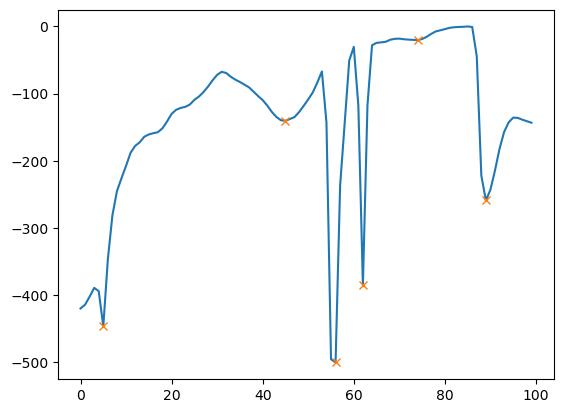

In [36]:
filt_cut = -filt[min:max]
filt_cut += np.max(filt[min:max])
peaks, _ = find_peaks(filt_cut, height=0)
plt.plot(-filt_cut)
plt.plot(peaks, -filt_cut[peaks], "x")
plt.show()

## Wrapping up
- How to filter in time with convolution
- Application to smoothing (what are the filters?)
- Application to finite differences computation (what filters do I need here?
- What is the median filter? What do I need it for?
- Examples of interesting points in a signal: peaks and valleys
 
### More in depth
- Compare smoothing in time or frequency with a Gaussian filter: what sigmas would you choose to obtain comparable results?